## Detecting Lanes and Lines
### Using Computer Vision Techniques
In this notebook we'll look at finding road edges and lane lines using computer vision techniques.

In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# plotting function for images
def plot(images, no_rows, no_cols, width = 10., height = 4., color='gray'):
    fig = plt.figure(1, (width, height))
    i = 0
    
    for image in images:
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(image, color)
        sub.axis("off")
        i += 1

    plt.show()

In [3]:
# Define the test image paths

test_path = "./test_images/"
sim_path = "./test_images_sim/"

In [4]:
import os

# Image test files
test_files = os.listdir(test_path)
sim_files = os.listdir(sim_path)

print(os.listdir(test_path))

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


In [5]:
images = [mpimg.imread(os.path.join(test_path, x)) for x in test_files]

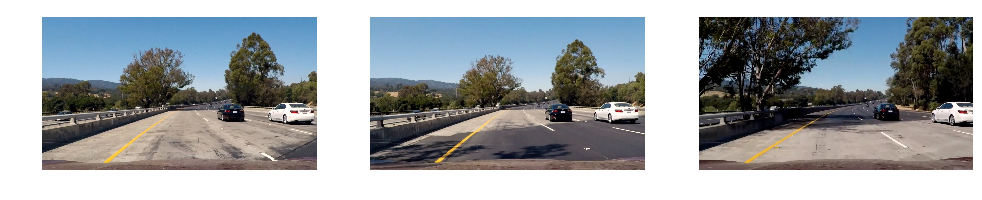

In [6]:
plot([images[2], images[5], images[6]], 1, 3, 12., 5.)

#### Colour Channels
Let's look at some colour channels to see which ones give us the best result.

##### YUV Colour Space

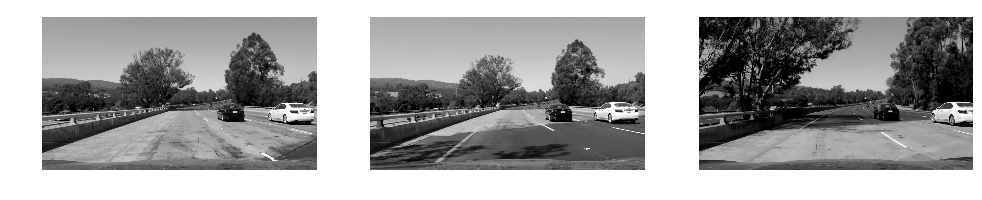

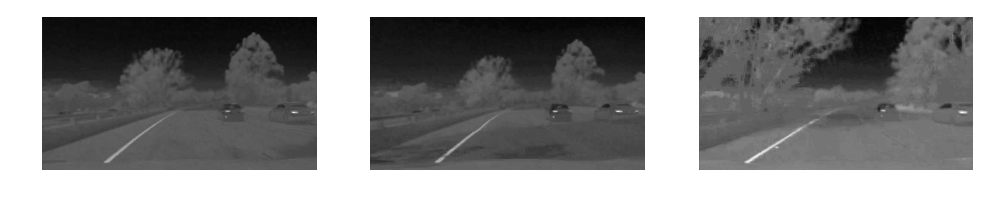

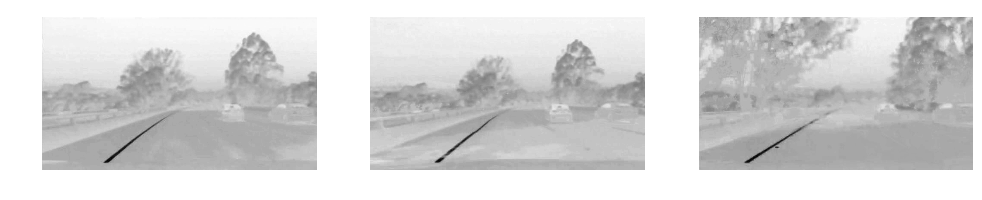

In [48]:
# Checking V channel in YUV colour space
Y_images = [cv2.cvtColor(x, cv2.COLOR_RGB2YUV)[:,:,0] for x in [images[2], images[5], images[6]]]
plot(Y_images, 1, 3, 12., 5.)
U_images = [cv2.cvtColor(x, cv2.COLOR_RGB2YUV)[:,:,1] for x in [images[2], images[5], images[6]]]
plot(U_images, 1, 3, 12., 5.)
V_images = [cv2.cvtColor(x, cv2.COLOR_RGB2YUV)[:,:,2] for x in [images[2], images[5], images[6]]]
plot(V_images, 1, 3, 12., 5.)

__The yellow lines are quite prominent here using the U and V channels, with the white lines being visible on the Y channel as expected with grayscale images.__

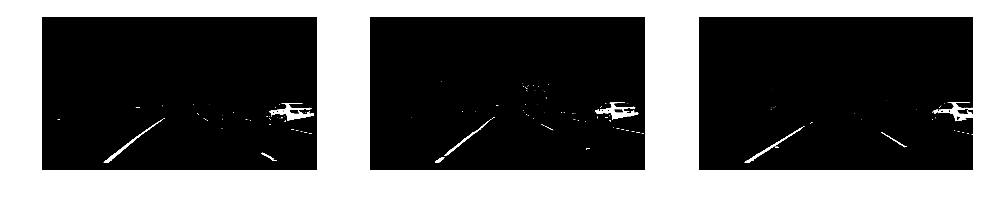

In [80]:
# Now threshold the YUV images
v_thresh = (0, 90)
y_thresh = (220, 255)

YV_thresh_images = []
for i in range(len(Y_images)):
    Y_image = Y_images[i]
    V_image = V_images[i]
    
    binary_result = np.zeros_like(image)
    binary_result[((Y_image >= y_thresh[0]) & (Y_image <= y_thresh[1]))] = 1
    binary_result[((V_image >= v_thresh[0]) & (V_image <= v_thresh[1]))] = 1
    
    YV_thresh_images.append(binary_result)

plot(YV_thresh_images, 1, 3, 12., 5.)

__Using thresholding of the YV channels it seems trivial to detect yellow and white lane lines.__

Let's try some others and compare the results.

##### HLS Colour Space

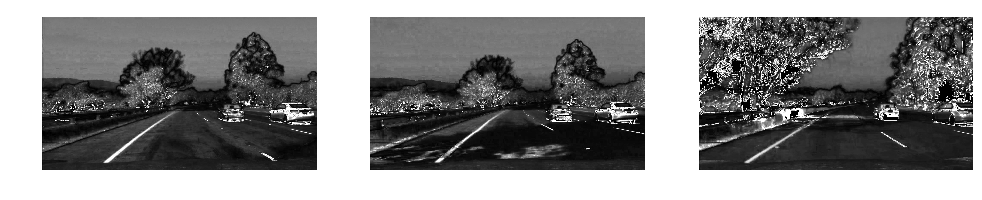

In [8]:
# Checking S channel in HLS colour space
HLS_images = [cv2.cvtColor(x, cv2.COLOR_RGB2HLS)[:,:,2] for x in [images[2], images[5], images[6]]]
plot(HLS_images, 1, 3, 12., 5.)

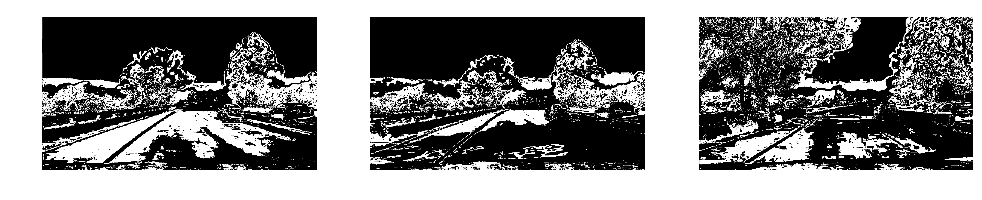

In [47]:
# Now threshold the HLS images
hls_thresh = (40, 90)
HLS_thresh_images = []
for image in HLS_images:
    binary_result = np.zeros_like(image)
    binary_result[((image >= hls_thresh[0]) & (image <= hls_thresh[1]))] = 1
    HLS_thresh_images.append(binary_result)

plot(HLS_thresh_images, 1, 3, 12., 5.)

##### HSV Colour Space

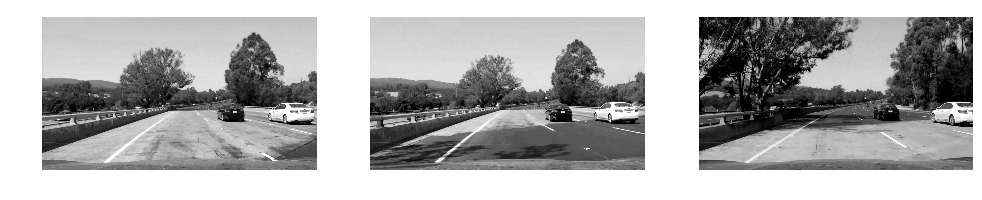

In [9]:
# Checking S channel in HLS colour space
HSV_images = [cv2.cvtColor(x, cv2.COLOR_RGB2HSV)[:,:,2] for x in [images[2], images[5], images[6]]]
plot(HSV_images, 1, 3, 12., 5.)

### Sobel Algorithm
Define the sobel algorithm functions for computing image gradients using the sobel derivative method.

In [ ]:
def compute_sobel(img, kernel):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # compute sobel derivatives
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    return [sobelx, sobely]

def sobel_threshold(img, kernel = 3, thresh = (20, 100), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(((scaled_sobelx >= thresh[0]) & (scaled_sobelx <= thresh[1])) | \
                   ((scaled_sobely >= thresh[0]) & (scaled_sobely <= thresh[1])))] = mask
    
    return binary_output

def sobel_magnitude(img, kernel = 3., thresh = (20, 100), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # compute the magnitude
    mag_sobel = np.sqrt(abs_sobelx**2. + abs_sobely**2.)
    
    # scale within 0-255 range
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = mask
    
    return binary_output

def sobel_direction(img, kernel=3, thresh = (0, np.pi/2), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # compute directional gradients
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # create mask
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = mask
    
    return binary_output

#### Image Tests
Test the algorithm on a number of real world images as well as ones from the Udacity simulator for robustness.

In [ ]:
images_ = [mpimg.imread(os.path.join(test_path, x)) for x in test_files]
plot(images_, 2, 4, 12., 5.)

In [ ]:
# Process images using Sobel
def process_images(files, kernel_size, sobel_thresh_min, sobel_thresh_max):
    
    result = []
    
    for file in files:
        img = mpimg.imread(file)
        
        sobel = sobel_magnitude(img, kernel_size, thresh = (sobel_thresh_min, sobel_thresh_max), mask = 255)
        result.append(sobel)
    
    return result

#### Real-world Test Images
Sobel algorithm run on images from the real-world.

In [ ]:
sobel_thresh_min = 20
sobel_thresh_max = 100
sobel_kernel = 9

test_files_ = [os.path.join(test_path, x) for x in test_files]
test_images = process_images(test_files_, sobel_kernel, sobel_thresh_min, sobel_thresh_max)

plot(test_images, 2, 4, 12., 5.)

#### Simulator Test Images
Sobel algorithm run on images from the Udacity self driving car simulator.

In [ ]:
sobel_thresh_min = 40
sobel_thresh_max = 70
sobel_kernel = 13

sim_files_ = [os.path.join(sim_path, x) for x in sim_files]
sim_images = process_images(sim_files_, sobel_kernel, sobel_thresh_min, sobel_thresh_max)
plot(sim_images, 5, 4, 12., 10.)

### Combine Sobel Detectors
Combine the sobel gradient detectors into a single Sobel superpower...

In [ ]:
def sobel_line_mask(img, kernels = (3,3,9), abs_thresh=(0,100), grad_thresh=(20,100), dir_thresh=(0.7,1.3), mask = 1):
    sobel_abs = sobel_threshold(img, kernel=kernels[0], thresh=abs_thresh, mask=mask)
    sobel_mag = sobel_magnitude(img, kernel=kernels[1], thresh=grad_thresh, mask=mask)
    sobel_dir = sobel_direction(img, kernel=kernels[2], thresh=dir_thresh, mask=mask)
    
    combined = np.zeros_like(sobel_dir)
    combined[((sobel_abs == mask) | ((sobel_mag == mask) & (sobel_dir == mask)))] = mask
    
    return combined

In [ ]:
# Process images using Sobel
def process_images_super(files, kernels=(3,3,9), abs_thresh=(0,100), grad_thresh=(20,100), dir_thresh=(0.7,1.3)):
    
    result = []
    
    for file in files:
        img = mpimg.imread(file)
        
        sobel = sobel_line_mask(img, kernels, abs_thresh, grad_thresh, dir_thresh, mask = 255)
        result.append(sobel)
    
    return result

#### Real-World Tests
Combined sobel detectors on real world images

In [ ]:
# combined real-world image tests
sobel_grad_thresh = (30, 80)
sobel_dir_thresh = (0.7, np.pi/2)
sobel_abs_thresh = (20, 80)
sobel_kernels = (3, 3, 3)

test_images = process_images_super(test_files_, sobel_kernels, sobel_grad_thresh, sobel_dir_thresh)

plot(test_images, 2, 4, 12., 5.)

#### Simulator Tests
Combined sobel detectors on real world images

In [ ]:
# combined simulator image tests
sobel_grad_thresh = (40, 70)
sobel_dir_thresh = (0, np.pi/2)
sobel_abs_thresh = (0, 100)
sobel_kernels = (3, 9, 13)

sim_images = process_images_super(sim_files_, sobel_kernels, sobel_grad_thresh, sobel_dir_thresh)
plot(sim_images, 5, 4, 12., 10.)